In [1]:
from airbnb_data import Data
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Questions:

**1) Can we predict price? using date and number of beds only<br>**
**</br>2) Increase predictive power of our models by combining date with other variables?<br>**
**3) How do these findings differ between boston and seattle</br>**

# Reading the data 

In [2]:
data_object = Data('price')

In [3]:
data = data_object.load_data()

# Quick look at our first table

In [4]:
seattle_calendar = data['seattle_calendar']

seattle_calendar.head(3)

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN


In [5]:
"""
First issue we encounter is that the price column which is what we are trying to predict
is not a numerical column. First we need to clean this column
"""
seattle_calendar['price'] = seattle_calendar['price'].str.replace(',', '') #removing ','
seattle_calendar['price'] = seattle_calendar['price'].str.replace('$', '') #removing dollar sign
seattle_calendar['price'] = seattle_calendar['price'].astype(float) #converting str to floats

"""
Same for boston
"""
boston_calendar = data['boston_calendar']
boston_calendar['price'] = boston_calendar['price'].str.replace(',', '')
boston_calendar['price'] = boston_calendar['price'].str.replace('$', '')
boston_calendar['price'] = boston_calendar['price'].astype(float)

# How many listings does each city has?

In [6]:
seattle_calendar.listing_id.nunique(), boston_calendar.listing_id.nunique()

(3818, 3585)

My working theory is that date has a big predictive power over price, we can quickly plot that to see if that's true

In [7]:
"""
A quick look at seattle's columns shows that date needs to be first converted to a datetime type
"""
seattle_calendar.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 42.5+ MB


In [8]:
seattle_calendar['date'] = pd.to_datetime(seattle_calendar['date'])
boston_calendar['date'] = pd.to_datetime(boston_calendar['date'])

In [9]:
seattle_date = seattle_calendar.set_index('date').groupby(pd.Grouper(freq='W')).price.median()

In [10]:
boston_date = boston_calendar.set_index('date').groupby(pd.Grouper(freq='W')).price.median()

# First thing we do is to plot potential features against the target and see if your theory holds up

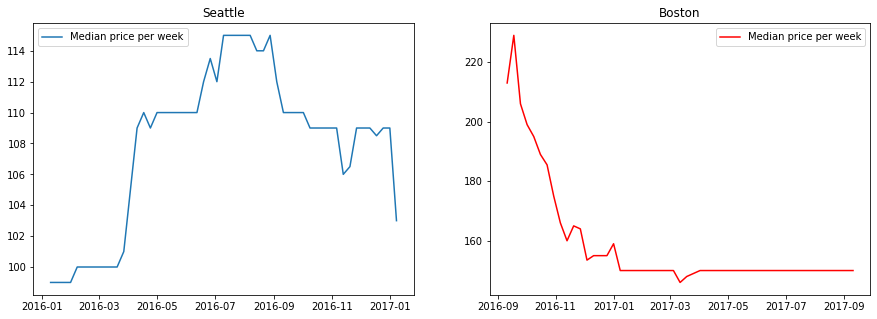

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].plot(seattle_date.index, seattle_date.values, label='Median price per week')
ax[0].set_title('Seattle')
ax[0].legend()
ax[1].plot(boston_date.index, boston_date.values, color='r', label='Median price per week')
ax[1].set_title('Boston');
ax[1].legend();

# Number of bedrooms

In [12]:
"""
Number of bedrooms and other property features are located in the listings table, we need to first merge
the listings table with calendar table
"""
seattle_listings = data['seattle_listings']
boston_listings = data['boston_listings']

In [13]:
seattle_df = seattle_calendar.reset_index().merge(seattle_listings[['id', 'bedrooms', 'beds', 'property_type', 'zipcode']], 
                            left_on=['listing_id'], right_on=['id'], how='left')
seattle_df = seattle_df.set_index('date')

boston_df = boston_calendar.reset_index().merge(boston_listings[['id', 'bedrooms', 'beds', 'property_type', 'zipcode']], 
                            left_on=['listing_id'], right_on=['id'], how='left')
boston_df = boston_df.set_index('date')

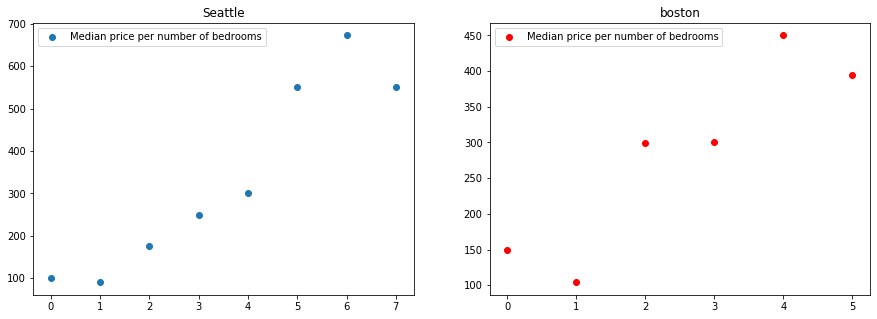

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].scatter(seattle_df.groupby('bedrooms').price.median().index, seattle_df.groupby('bedrooms').price.median(), 
              label='Median price per number of bedrooms')
ax[0].set_title('Seattle')
ax[0].legend()
ax[1].scatter(boston_df.groupby('bedrooms').price.median().index, boston_df.groupby('bedrooms').price.median(), 
              label='Median price per number of bedrooms', color='r')
ax[1].set_title('boston')
ax[1].legend();

# One more check before we start running our OLS model

In [15]:
"""
The biggest column by number of nan's is our target; price. 

The percentage of nan values in the other columns are all less than 1% so it is unlikely to have a material impact
on our analysis.

In this case I choose to dropna rather than doing data imputation.
"""

seattle_df.isna().mean().sort_values(ascending=False)

price            0.329390
zipcode          0.001833
bedrooms         0.001572
property_type    0.000262
beds             0.000262
id               0.000000
available        0.000000
listing_id       0.000000
index            0.000000
dtype: float64

# Experiments

In [16]:
"""
This is the varianle we will uset to record out results
"""

experiments = {}

# Liner Model 

In [17]:
df_ = seattle_df.reset_index().dropna(subset=['price', 'date', 'bedrooms']).copy()
df_['date']= df_['date'].map(datetime.datetime.toordinal)

X = df_[['date', 'bedrooms']]
y = df_[['price']]

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_train_preds = lm_model.predict(X_train)
y_test_preds = lm_model.predict(X_test)
train_score = r2_score(y_train, y_train_preds)
test_score = r2_score(y_test, y_test_preds)

experiments['experiment_1'] = (round(train_score, 3), round(test_score,3))

print(f"Train R squared: {round(train_score, 3)}, Test R squared: {round(test_score,3)}")

Train R squared: 0.399, Test R squared: 0.403


# Property Type

Property type feature is a categorical feature, we need to create dummy variables before we can incorporate it into our model

In [18]:
df_ = seattle_df.reset_index().copy() #creating a copy of our default dataframe
df_ = pd.concat([df_.drop('property_type', axis=1),#dropping original property_type column   
                 pd.get_dummies(df_.property_type, prefix='dummy')],axis=1) #creating dummy variables using pandas

df_['date'] = pd.to_datetime(df_['date']) #changing date columns type to datetime
df_['date']= df_['date'].map(datetime.datetime.toordinal) #changing from datetime to ordinal

df_ = df_.dropna()
columns = [x for x in df_.columns if 'dummy' in x or 'bedrooms' in x]
X = df_[columns]
y = df_[['price']]

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_train_preds = lm_model.predict(X_train)
y_test_preds = lm_model.predict(X_test)

train_score = r2_score(y_train, y_train_preds)
test_score = r2_score(y_test, y_test_preds)

experiments['experiment_2'] = (round(train_score, 3), round(test_score,3))

print(f"Train R squared: {round(train_score, 3)}, Test R squared: {round(test_score,3)}")

Train R squared: 0.442, Test R squared: 0.445


# Adding Zipcode

In [19]:
seattle_df.zipcode = seattle_df.zipcode.replace("99\n98122", "98122") #fixing what seems to be a typo
df_ = seattle_df.reset_index().copy()
df_ = pd.concat([df_.drop('zipcode', axis=1),
          pd.get_dummies(df_.zipcode, prefix='dummy')],axis=1)

df_['date'] = pd.to_datetime(df_['date'])
df_['date']= df_['date'].map(datetime.datetime.toordinal)

df_ = df_.dropna()

columns = [x for x in df_.columns if 'dummy' in x or 'bedrooms' in x]
X = df_[columns]
y = df_[['price']]

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_train_preds = lm_model.predict(X_train)
y_test_preds = lm_model.predict(X_test)

train_score = r2_score(y_train, y_train_preds)
test_score = r2_score(y_test, y_test_preds)

experiments['experiment_3'] = (round(train_score, 3), round(test_score,3))

print(f"Train R squared: {round(train_score, 3)}, Test R squared: {round(test_score,3)}")

Train R squared: 0.49, Test R squared: 0.493


# Combining Everything

In [20]:
df_ = seattle_df.reset_index().copy()
df_ = pd.concat([df_.drop('zipcode', axis=1),
          pd.get_dummies(df_.zipcode, prefix='dummy')],axis=1)
df_ = pd.concat([df_.drop('property_type', axis=1),
                 pd.get_dummies(df_.property_type, prefix='dummy')],axis=1)

df_['date'] = pd.to_datetime(df_['date'])
df_['date']= df_['date'].map(datetime.datetime.toordinal)

df_ = df_.dropna()

X = df_.drop(['listing_id', 'available', 'price', 'id'], axis=1)
y = df_[['price']]

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_train_preds = lm_model.predict(X_train)
y_test_preds = lm_model.predict(X_test)

train_score = r2_score(y_train, y_train_preds)
test_score = r2_score(y_test, y_test_preds)

experiments['experiment_4'] = (round(train_score, 3), round(test_score,3))

print(f"Train R squared: {round(train_score, 3)}, Test R squared: {round(test_score,3)}")

Train R squared: 0.533, Test R squared: 0.534


In [21]:
results = pd.DataFrame.from_dict(experiments).transpose()
results.columns = ['Train', 'Test']

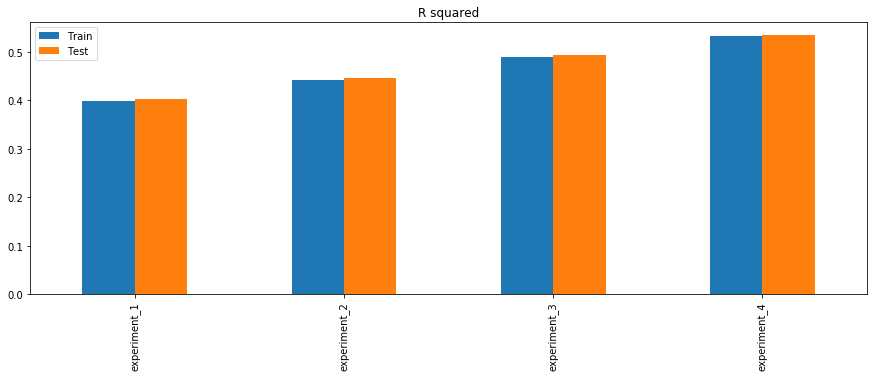

In [22]:
results.plot(kind='bar', figsize=(15,5));
plt.title('R squared');

# Finally how does this model perform with Boston data

In [23]:
df_ = boston_df.reset_index().copy()
df_ = pd.concat([df_.drop('zipcode', axis=1),
          pd.get_dummies(df_.zipcode, prefix='dummy')],axis=1)
df_ = pd.concat([df_.drop('property_type', axis=1),
                 pd.get_dummies(df_.property_type, prefix='dummy')],axis=1)

df_['date'] = pd.to_datetime(df_['date'])
df_['date']= df_['date'].map(datetime.datetime.toordinal)

df_ = df_.dropna()

X = df_.drop(['listing_id', 'available', 'price', 'id'], axis=1)
y = df_[['price']]

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_train_preds = lm_model.predict(X_train)
y_test_preds = lm_model.predict(X_test)

train_score = r2_score(y_train, y_train_preds)
test_score = r2_score(y_test, y_test_preds)

print(f"Train R squared: {round(train_score, 3)}, Test R squared: {round(test_score,3)}")

Train R squared: 0.379, Test R squared: 0.368
